<a href="https://colab.research.google.com/github/kkfwees/cs230_2020/blob/master/CS230_RCNN_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-cs_xmy8t
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-cs_xmy8t
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266998 sha256=1ae4e725dbedd68ca5d0536ee1493fb978d308759e30656262433c698f504828
  Stored in directory: /tmp/pip-ephem-wheel-cache-rlc_9wkr/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.0
    Uninstalling pycocotools-2.0.0:
      Successfully uninstalled pycocotools-2.0.0


In [0]:
#get all needed resources
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
import torch.utils.data

In [0]:
# mount data to google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#if this does not run: create a shortcut to Eleni Shared CS230 drive 
os. listdir('/content/drive/My Drive/CS230/data/multi_color_batch1_2_unzipped/masks')[-10:]

['695_640x640_labeled.png',
 '6_640x640_labeled.png',
 '8324_640x640_labeled.png',
 '906_640x640_labeled.png',
 '9093_640x640_labeled.png',
 '921_640x640_labeled.png',
 '930_640x640_labeled.png',
 '940_640x640_labeled.png',
 '950_640x640_labeled.png',
 '97_640x640_labeled.png']

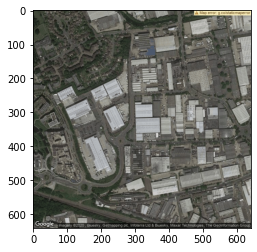

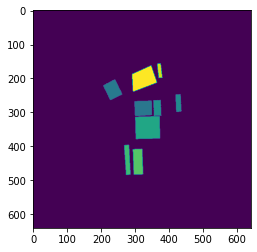

[  0  59  61  71  76  88 102 110 139 149]
[[285, 247, 434, 481], [206, 204, 434, 276], [354, 248, 434, 310], [354, 265, 375, 310], [210, 206, 435, 472], [268, 298, 426, 483], [293, 408, 322, 482], [291, 157, 379, 232], [291, 163, 363, 239]]


In [0]:
#test the datasest class
test_img = Image.open('/content/drive/My Drive/CS230/data/multi_color_batch1_2_unzipped/unlabeled/1172_640x640.png').convert("RGB")
plt.imshow(test_img)
plt.show()
test_mask = Image.open('/content/drive/My Drive/CS230/data/multi_color_batch1_2_unzipped/masks/1172_640x640_labeled.png').convert("L")
plt.imshow(test_mask)
plt.show()

test_mask = np.array(test_mask)
# instances are encoded as different colors
test_obj_ids = np.unique(test_mask)
print(test_obj_ids)

# first id is the background, so remove it
test_obj_ids = test_obj_ids[1:]

test_masks = test_mask == test_obj_ids[:, None, None]

# get bounding box coordinates for each mask
test_num_objs = len(test_obj_ids)
test_boxes = []
for i in range(test_num_objs):
    pos = np.where(test_masks[i])
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])
    test_boxes.append([xmin, ymin, xmax, ymax])


print(test_boxes)


In [0]:
class SatelliteDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root,  "/content/drive/My Drive/CS230/data/multi_color_batch1_2_unzipped/unlabeled"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "/content/drive/My Drive/CS230/data/multi_color_batch1_2_unzipped/masks"))))


    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root,  "/content/drive/My Drive/CS230/data/multi_color_batch1_2_unzipped/unlabeled", self.imgs[idx])
        mask_path = os.path.join(self.root, "/content/drive/My Drive/CS230/data/multi_color_batch1_2_unzipped/masks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        
  
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        # mask = Image.open(mask_path)
        #mask = np.array(mask)
        #print(mask.shape)
        mask = Image.open(mask_path).convert("L")
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)

        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [0]:
test_dataset = SatelliteDataset('/content/drive/My Drive/CS230/data/multi_color_batch1_2_unzipped')
#test_dataset[0]

In [0]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [0]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 8222 (delta 2), reused 1 (delta 0), pack-reused 8219
Receiving objects: 100% (8222/8222), 10.20 MiB | 22.03 MiB/s, done.
Resolving deltas: 100% (5653/5653), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be37608 version check against PyTorch's CUDA version


In [0]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [0]:
# use our dataset and defined transformations
dataset = SatelliteDataset('/content/drive/My Drive/CS230/data/multi_color_batch1_2_unzipped', get_transform(train=True))
dataset_test = SatelliteDataset('/content/drive/My Drive/CS230/data/multi_color_batch1_2_unzipped', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-42])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-42:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=1,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=1,
    collate_fn=utils.collate_fn)
#print(dataset[0])

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


In [0]:
# let's train it for 10 epochs
num_epochs = 5

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


Epoch: [0]  [  0/212]  eta: 0:03:02  lr: 0.000029  loss: 0.7549 (0.7549)  loss_classifier: 0.1369 (0.1369)  loss_box_reg: 0.0778 (0.0778)  loss_mask: 0.4906 (0.4906)  loss_objectness: 0.0430 (0.0430)  loss_rpn_box_reg: 0.0065 (0.0065)  time: 0.8620  data: 0.6866  max mem: 1326
Epoch: [0]  [ 10/212]  eta: 0:01:33  lr: 0.000265  loss: 0.8267 (0.8804)  loss_classifier: 0.2102 (0.2228)  loss_box_reg: 0.1492 (0.1570)  loss_mask: 0.3405 (0.3282)  loss_objectness: 0.0708 (0.1008)  loss_rpn_box_reg: 0.0305 (0.0717)  time: 0.4620  data: 0.2970  max mem: 1348
Epoch: [0]  [ 20/212]  eta: 0:01:43  lr: 0.000502  loss: 0.8060 (0.8979)  loss_classifier: 0.2040 (0.2134)  loss_box_reg: 0.1395 (0.1426)  loss_mask: 0.3458 (0.3557)  loss_objectness: 0.0708 (0.1057)  loss_rpn_box_reg: 0.0305 (0.0805)  time: 0.5255  data: 0.3632  max mem: 1361
Epoch: [0]  [ 30/212]  eta: 0:01:30  lr: 0.000739  loss: 0.7349 (0.8506)  loss_classifier: 0.1734 (0.2093)  loss_box_reg: 0.1086 (0.1411)  loss_mask: 0.3701 (0.3433) 

In [0]:
# pick one image from the test set
img, _ = dataset_test[9]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [0]:
#prediction

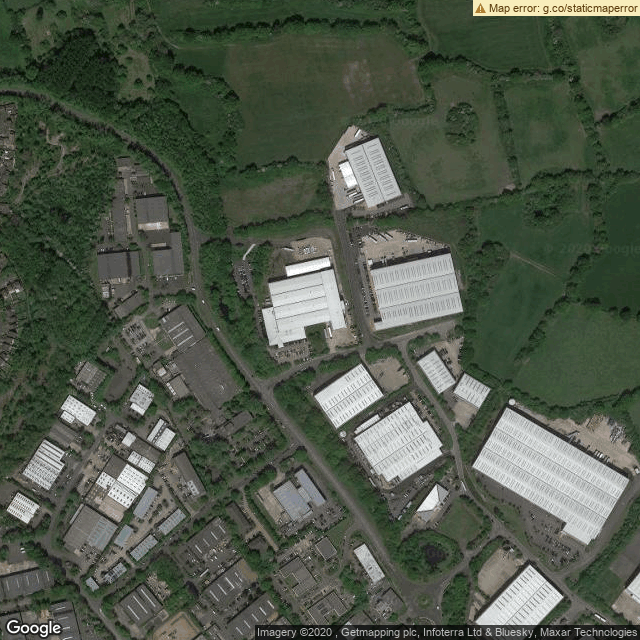

In [0]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

In [0]:
#test_img = Image.open('/content/drive/My Drive/CS230/data/multi_color_batch1_2_unzipped/masks/2632_640x640_labeled.png').convert("RGB")
#plt.imshow(test_img)

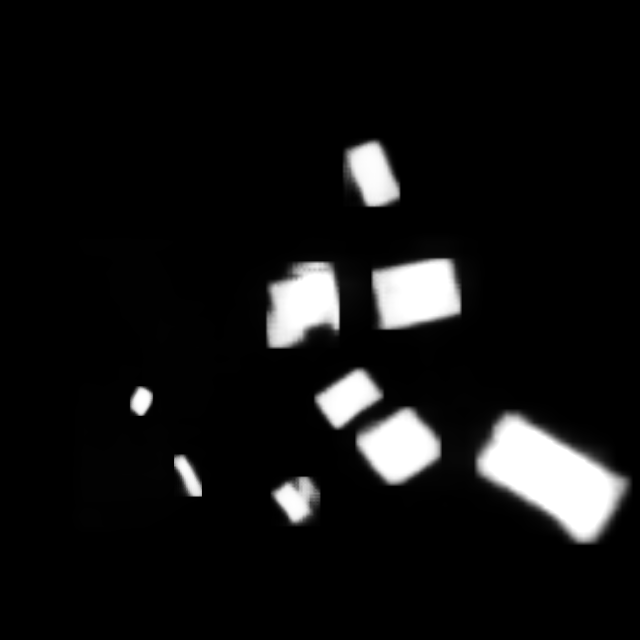

In [0]:
#Image.fromarray(prediction[0]['masks'][3, 0].mul(255).byte().cpu().numpy()) 
image_sum = prediction[0]['masks'][0, 0]
for i in range(1, 10):
  image_sum = image_sum + prediction[0]['masks'][i, 0]
  image_sum[image_sum > 1] = 1

Image.fromarray(image_sum.mul(255).byte().cpu().numpy())
